# Objetivo

Identificar a melhor relação entre as variáveis explicativas e a resposta por uma função, Y = F(X|$\theta$). A priori, tem-se interesse em atingir todos os clientes classificados como churn, como descrito na contextualização do README.

Nesse contexto, faria sentido pensar em métricas como maximizar o recall (taxa de verdadeiro positivo) dado que o custo de se ter um falso negativo é mais caro. Mas, também precisa ser levado em consideração que o gasto com um público que é falso positivo é comprometedor para a campanha, ou seja, um gasto desnecessário foi feito.

Na etapa de ajustar o XGBoost aos dados, foi preciso realiazar o downgrade da scikit-learn devido ao erro de compatibilidade com o xgboost. Isso foi mencionado na parte do modelo XGBoost.

# Pacotes

In [60]:
#!pip install mlflow
#!pip install xgboost
#!pip install shap

In [68]:
# Precisei fazer o downgrade do numpy, por conflito de versão com o numba.
    # https://medium.com/@pies052022/importerror-numba-needs-numpy-1-21-or-less-solved-7bc8690a19a5

#!pip install numpy==2.0

In [ ]:
#!pip install scikit-learn --upgrade

In [1]:
from deltalake import DeltaTable, write_deltalake
import mlflow
from mlflow.models import infer_signature
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import shap
import Funcoes
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score, average_precision_score, brier_score_loss, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_recall_curve
import xgboost as xgb

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Valida a versão do numpy

print(np.__version__)

2.0.0


# Leitura da base v1

In [2]:
dados = DeltaTable("../1.Variaveis/tmp/dados_pp_v1").to_pandas()
dados.drop(['__index_level_0__'], axis=1, inplace=True)
dados.head()

,Customer_Age,Dependent_count,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,vfm,pmcc,...,Income_Category_5. >= 120k,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Education_Level_v2_1.Uneducated,Education_Level_v2_2.High School,Education_Level_v2_3.Graduate,Education_Level_v2_4.Post-Graduate,Attrition_Flag,type
0,-0.784196,0.494019,1.403132,-1.337898,0.498943,0.963894,0.282975,-0.328225,-0.175537,-0.421450,...,0,0,0,0,0,0,1,0,0,Treino
1,0.720070,0.494019,-0.525933,0.641818,1.408428,-0.165769,-1.527806,-0.194304,-0.208685,-1.054789,...,0,0,0,0,0,0,1,0,0,Treino
2,1.346848,0.494019,-0.525933,-0.348040,0.498943,0.864865,0.894171,0.056797,-0.571459,-0.686436,...,0,0,0,0,0,0,0,1,0,Treino
3,0.218648,-0.279306,-0.525933,0.641818,-1.320028,-0.412731,0.369637,0.851953,0.252749,2.406712,...,0,0,0,0,0,0,1,0,0,Treino
4,-2.539173,-1.825958,0.117089,1.631675,1.408428,-0.858972,0.346832,-1.144306,-0.064053,-0.071911,...,0,0,0,0,1,0,0,0,0,Treino


In [3]:
dados.dtypes

Customer_Age                          float64
Dependent_count                       float64
Total_Relationship_Count              float64
Months_Inactive_12_mon                float64
Contacts_Count_12_mon                 float64
Total_Revolving_Bal                   float64
Total_Amt_Chng_Q4_Q1                  float64
Total_Ct_Chng_Q4_Q1                   float64
vfm                                   float64
pmcc                                  float64
Gender_M                                int32
Marital_Status_Married                  int32
Marital_Status_Single                   int32
Marital_Status_Unknown                  int32
Income_Category_1.< 40k                 int32
Income_Category_2. >= 40k & < 60k       int32
Income_Category_3. >= 60k & < 80k       int32
Income_Category_4. >= 80k & < 120k      int32
Income_Category_5. >= 120k              int32
Card_Category_Gold                      int32
Card_Category_Platinum                  int32
Card_Category_Silver              

## Separação das bases

Se classificássemos toda a base como "não churn" ou Attrition_Flag = 0, teríamos a métrica de acurácia em aproximadamente 83%. Utilizaremos esse valor como threshold, além de avaliar outras métricas como recall (TPR), precisão e FPR.

In [3]:
dados_treino = dados[dados.type == 'Treino'].drop(['type'], axis=1)
dados_val = dados[dados.type == 'Validacao'].drop(['type'], axis=1)
dados_teste = dados[dados.type == 'Teste'].drop(['type'], axis=1)

In [4]:
X_treino = dados_treino.drop(['Attrition_Flag'], axis=1)
y_treino = dados_treino['Attrition_Flag']

X_val = dados_val.drop(['Attrition_Flag'], axis=1)
y_val = dados_val['Attrition_Flag']

In [9]:
# A representatividade absoluta da variável target é baixa nas bases de validação e teste

dados_treino['Attrition_Flag'].value_counts(), dados_val['Attrition_Flag'].value_counts(), dados_teste['Attrition_Flag'].value_counts()

(Attrition_Flag
 0    6140
 1    1175
 Name: count, dtype: int64,
 Attrition_Flag
 0    1084
 1     208
 Name: count, dtype: int64,
 Attrition_Flag
 0    1276
 1     244
 Name: count, dtype: int64)

In [11]:
dados_treino['Attrition_Flag'].value_counts()/dados_treino.shape[0], dados_val['Attrition_Flag'].value_counts()/dados_val.shape[0], dados_teste['Attrition_Flag'].value_counts()/dados_teste.shape[0]

(Attrition_Flag
 0    0.839371
 1    0.160629
 Name: count, dtype: float64,
 Attrition_Flag
 0    0.839009
 1    0.160991
 Name: count, dtype: float64,
 Attrition_Flag
 0    0.839474
 1    0.160526
 Name: count, dtype: float64)

# Modelos baselines 

Por hora, aplicaremos alguns modelos sem a tunagem dos hiperparâmetros, considerando todas as variáveis e avaliaremos o desempenho na base de validação.

## Cria experimento

In [10]:
#experiment = mlflow.create_experiment(name = 'Modelos_Baselines',
#                                      artifact_location = 'Artf_Modelos_Baselies',
#                                      tags = {'Environment': 'Development', 'Version': '1.0.0'}
#                                      )

In [11]:
#experiment

'409923951546246489'

In [5]:
experiment = mlflow.set_experiment(experiment_id='409923951546246489')

In [6]:
experiment.experiment_id

'409923951546246489'

## Random forest - scikit-learn 1.6.0

A versão da scikit-learn está disponível no requirements.txt, dentro dos artefatos da run_name da RF.

Pelas métricas de treino e validação, é possível identificar que o modelo se sobreajustou. A métrica AUC-PR mostra que se perde cerca de 20% da área sobre esta curva quando se compara validação (80%) e treino (100%).

In [14]:
if __name__ == '__main__':
    
    with mlflow.start_run(run_name = 'Baseline_RF', experiment_id = experiment.experiment_id) as run: 

        rf = RandomForestClassifier()
        rf.fit(X_treino, y_treino)

        # Log dos parâmetros do modelo
        mlflow.log_params(rf.get_params())

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, rf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, rf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, rf.predict_proba(X_treino)[:,1]))

            # OBS: o ponto de corte utilizado é o 0.5 (ainda não otimizamos esse ponto)
        mlflow.log_metric('F1_Treino', f1_score(y_treino, rf.predict(X_treino)))
        mlflow.log_metric('Precision_Treino', precision_score(y_treino, rf.predict(X_treino)))
        mlflow.log_metric('Recall_Treino', recall_score(y_treino, rf.predict(X_treino)))
        mlflow.log_metric('Acuracia_Treino', accuracy_score(y_treino, rf.predict(X_treino)))

        # Log das métricas na base de VALIDAÇÃO
        mlflow.log_metric('AUC_PR_Val', average_precision_score(y_val, rf.predict_proba(X_val)[:,1]))
        mlflow.log_metric('AUC_ROC_Val', roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))
        mlflow.log_metric('BS_Val', brier_score_loss(y_val, rf.predict_proba(X_val)[:,1]))

                    # OBS: o ponto de corte utilizado é o 0.5 (ainda não otimizamos esse ponto)
        mlflow.log_metric('F1_Val', f1_score(y_val, rf.predict(X_val)))
        mlflow.log_metric('Precision_Val', precision_score(y_val, rf.predict(X_val)))
        mlflow.log_metric('Recall_Val', recall_score(y_val, rf.predict(X_val)))
        mlflow.log_metric('Acuracia_Val', accuracy_score(y_val, rf.predict(X_val)))
        
        # Log do schema das variáveis do modelo e do modelo
        signature = infer_signature(X_treino, rf.predict_proba(X_treino))
        mlflow.sklearn.log_model(rf, signature=signature, artifact_path='modelo')

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [ ]:
logged_model = 'runs:/46f1b5c5341142b69a7e3ec7317f9993/modelo'

# Carrega o modelo com a flavor da sklearn

rf = mlflow.sklearn.load_model(logged_model)

# Predict em um Pandas DataFrame.

rf.predict_proba(X_treino)

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


array([[1.  , 0.  ],
       [0.9 , 0.1 ],
       [0.98, 0.02],
       ...,
       [0.96, 0.04],
       [0.98, 0.02],
       [1.  , 0.  ]])

### Importância das variáveis

As duas primeiras variáveis mais importantes coincidem com as variáveis mais importantes em termos de IV. Além disso, identifica-se que as 12 primeiras variáveis acumulam cerca de 91% de importância e estão listadas com IV alto, por exemplo, Contacts_Count_12_mon, Months_Inactive_12_mon, Total_Relationship_Count e Total_Amt_Chng_Q4_Q1.

In [9]:
np.cumsum(np.sort(rf.feature_importances_)[::-1])

array([0.19940778, 0.36248545, 0.46540322, 0.56394182, 0.65723644,
       0.71527244, 0.7720982 , 0.82617013, 0.86997731, 0.89719866,
       0.90855356, 0.91839887, 0.92798364, 0.93742017, 0.94577973,
       0.95354765, 0.96065928, 0.96731936, 0.97354924, 0.97902821,
       0.98430525, 0.98935835, 0.99433515, 0.99792843, 0.99976263,
       1.        ])

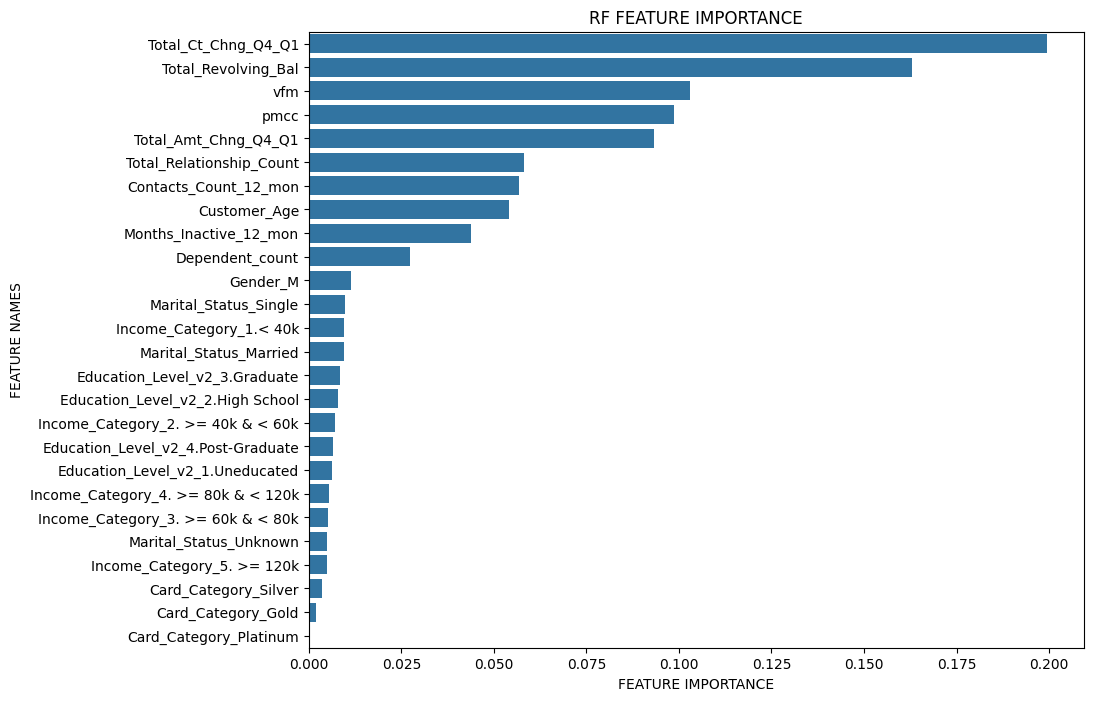

In [11]:
Funcoes.plot_feature_importance(rf.feature_importances_, rf.feature_names_in_, 'RF')

### Curva de calibração e histograma das probabilidades preditas

O histograma abaixo mostra a distrbuição dos valores preditos. A maior concentração está próxima de zero, porque a base está concentrada em clientes que não são churn. Mas, também é possível ver uma pequena concentração de clientes em valores preditos maiores. 

Pelo gráfico de calibração, usando os decis e os intervalos com mesmo comprimento, nota-se que em um dado momento superestima-se em média as probabilidades (primeiros intervalos) e em outro subestima-se em média as probabilidades (últimos intervalos). Entretanto, é possível notar que a magnitude das probabilidades direcionam para as classes corretas (ou 0 ou 1).

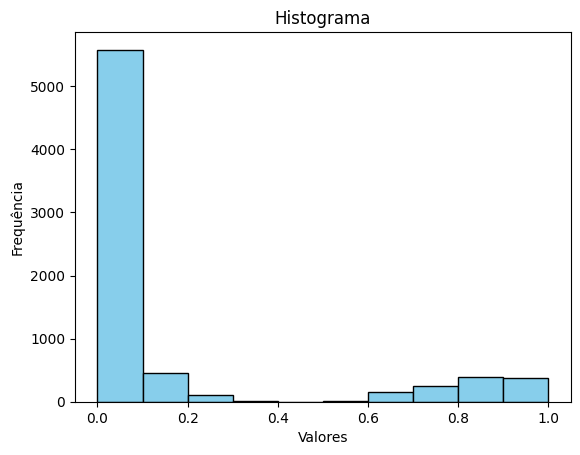

In [41]:
Funcoes.plot_histograma('Prob_predita', pd.DataFrame(rf.predict_proba(X_treino)[:,1]).rename(columns={0: 'Prob_predita'}), label=None)

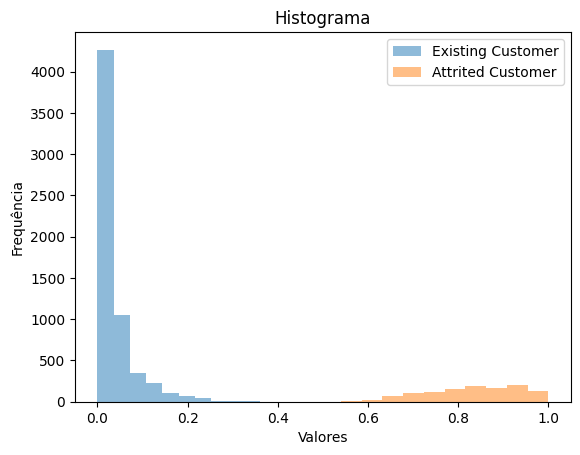

In [52]:
Funcoes.plot_histograma('Prob_predita', pd.concat([pd.Series(rf.predict_proba(X_treino)[:,1]).reset_index(drop = True), y_treino.reset_index(drop = True)], axis=1).rename(columns={0: 'Prob_predita'}), label='Attrition_Flag')

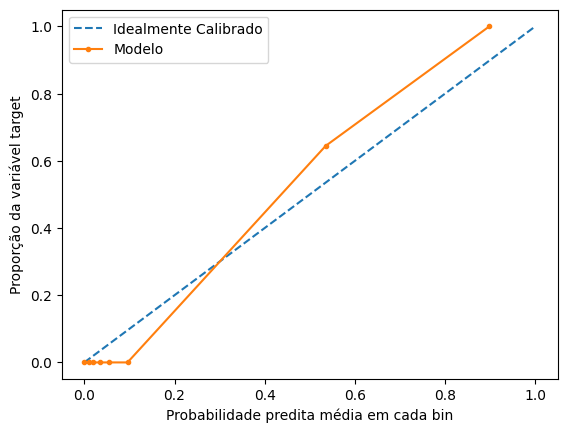

In [26]:
Funcoes.grafico_calibracao(y_treino, rf.predict_proba(X_treino)[:,1], nbins=10, strategy='quantile')

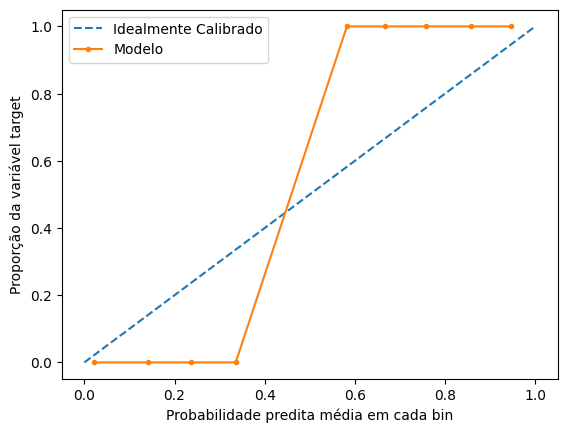

In [57]:
Funcoes.grafico_calibracao(y_treino, rf.predict_proba(X_treino)[:,1], nbins=10, strategy='uniform')

Abaixo, identica-se que a distribuição das probabilidades preditas são um pouco diferentes comparada com a base de treino. Agora, comete-se alguns erros como é possível notar o histograma graficado com base na cor da variável target. 

Na base de validação (e de teste) a quantidade de clientes churn é baixa em valores absolutos. A curva de calibração para a base de valiação mostra-se mais próxima da curva ideal, com alguns decis e intervalos de superestimação e subestimação.

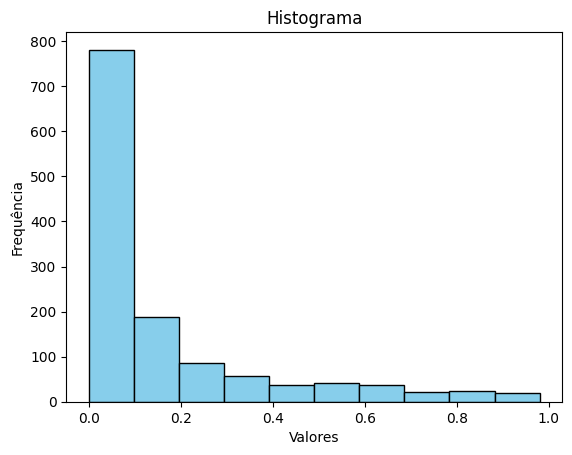

In [42]:
Funcoes.plot_histograma('Prob_predita', pd.DataFrame(rf.predict_proba(X_val)[:,1]).rename(columns={0: 'Prob_predita'}), label=None)

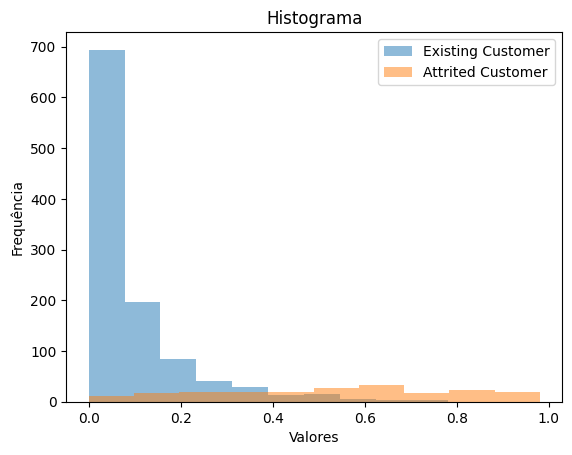

In [51]:
Funcoes.plot_histograma('Prob_predita', pd.concat([pd.Series(rf.predict_proba(X_val)[:,1]).reset_index(drop = True), pd.Series(y_val).reset_index(drop = True)], axis=1).rename(columns={0: 'Prob_predita'}), label='Attrition_Flag')

Observe que a procura do melhor ponto de corte que otimiza a área sobre a curva PR, com o uso do f1-score, apontou para um valor abaixo de 0.5. Isso significa que se admite mais falso positivo (FP) e, consequentemente, redução de falso negativo (FN).

In [11]:
# Avaliação do melhor ponto de corte com o uso da base de validação

precision, recall, thresholds = precision_recall_curve(y_val, rf.predict_proba(X_val)[:,1])

In [36]:
# Melhor threshold que fornece o melhor f1-score (média harmônica entre precisão (Positive Predicted Value ou PPV) e recall (TPR))

f1_scores = 2 * (precision*recall) / (precision + recall)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1 = f1_scores[best_threshold_index]

print('Valor ótimo do f1-score:', best_f1,', com o ponto de corte ótimo:', best_threshold)

Valor ótimo do f1-score: 0.7245657568238213 , com o ponto de corte ótimo: 0.37


Observe que a procura do melhor ponto de corte, com o uso da precisão, apontou para um valor acima de 0.5. No histograma anterior, percebe-se que a quantidade de falso positivo (FP) seria zerada, entretanto a quantidade de falso negativo (FN) seria a máxima. Os clientes mapeados como FN, não seriam atingidos por nenhuma campanha. Potencialmente, o custo de trazê-los novamente para a instituição (uso de cartão de crédito) seria maior do que o custo atrelado a campanha!

In [32]:
# Melhor threshold que fornece a melhor precisão (foco total no PPV)

best_threshold_index_v2 = np.argmax(precision)
best_threshold_v2 = thresholds[best_threshold_index_v2]
best_PPV = precision[best_threshold_index_v2]

print('Valor ótimo da precisão:', best_PPV,', com o ponto de corte ótimo:', best_threshold_v2)

Valor ótimo da precisão: 1.0 , com o ponto de corte ótimo: 0.79


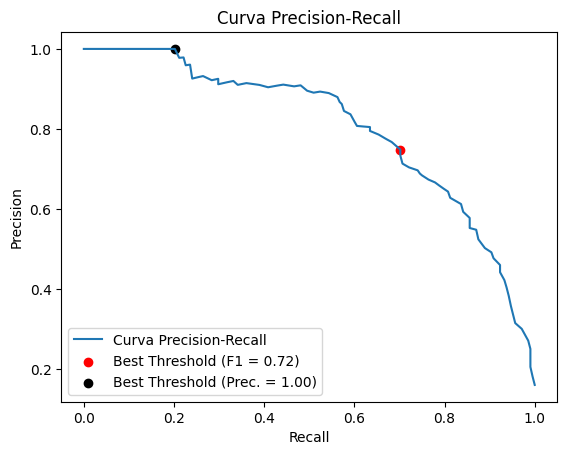

In [38]:
# Gráfico da curva PR

plt.plot(recall, precision, label='Curva Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')

# Pontos ótimo para o f1 score
plt.scatter(recall[best_threshold_index], precision[best_threshold_index], color='red', label=f'Best Threshold (F1 = {best_f1:.2f})')
plt.legend(loc='best')

plt.scatter(recall[best_threshold_index_v2], precision[best_threshold_index_v2], color='black', label=f'Best Threshold (Prec. = {best_PPV:.2f})')
plt.legend(loc='best')

plt.show()

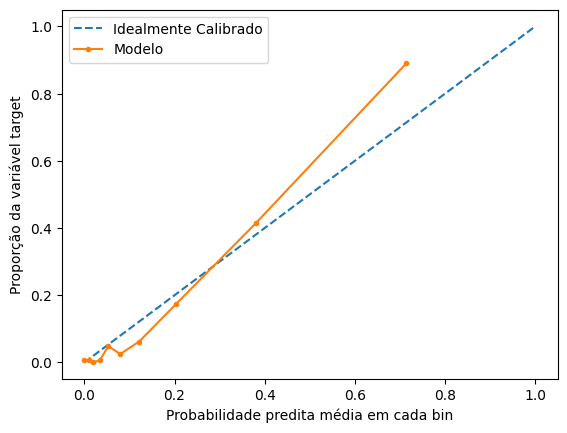

In [56]:
# https://endtoenddatascience.com/chapter11-machine-learning-calibration

Funcoes.grafico_calibracao(y_val, rf.predict_proba(X_val)[:,1], nbins=10, strategy='quantile')

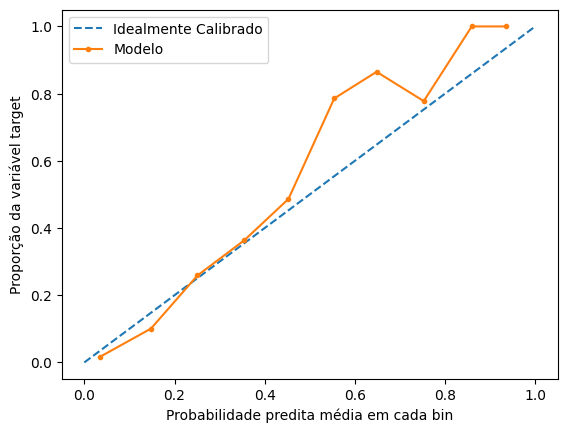

In [55]:
Funcoes.grafico_calibracao(y_val, rf.predict_proba(X_val)[:,1], nbins=10, strategy='uniform')

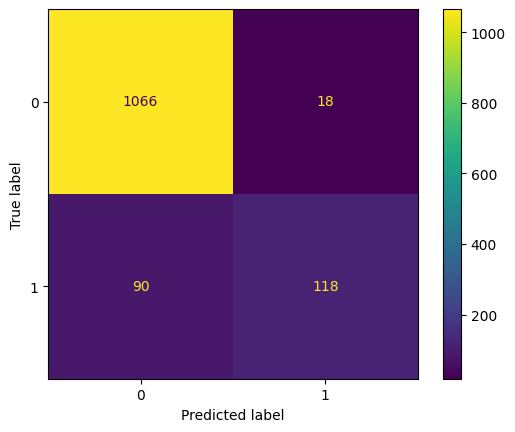

In [18]:
confusion_matrix = confusion_matrix(y_val, rf.predict(X_val))
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

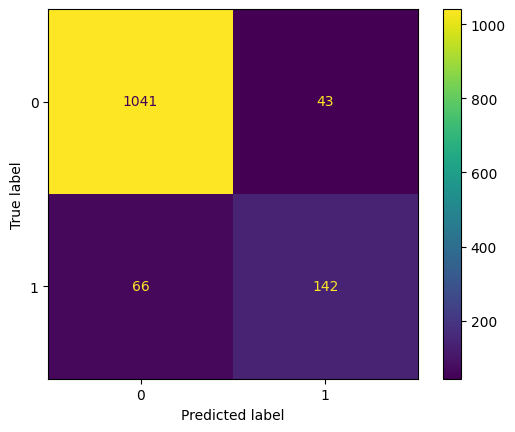

In [44]:
confusion_matrix = confusion_matrix(y_val, rf.predict_proba(X_val)[:,1] > best_threshold)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [30]:
print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1084
           1       0.87      0.57      0.69       208

    accuracy                           0.92      1292
   macro avg       0.89      0.78      0.82      1292
weighted avg       0.91      0.92      0.91      1292



### Interpretabilidade

Será usado o SHAP Values para entender a relação entre a magnitude das variáveis explicativas e a variável resposta.

In [8]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_val)

In [46]:
# shap_values possui os shap values para cada observação. Dessa forma, quando se olha shap_values[0] terá os valores de shap para a classe 0 (primeira coluna do array)
# e terá os valores de shap para a classe 1 (segunda coluna do array).
# Na mesma variável shap_values, é possível ver o expected_value para cada uma das classes, que é basicamente o valor médio da variável target e por fim tem-se o .base_values
# que basicamente é o array da variável explicativa, no nosso caso, a replicação do X_val.

shap_values

.values =
array([[[-2.64234526e-03,  2.64234526e-03],
        [-6.62743666e-03,  6.62743666e-03],
        [ 3.36669722e-02, -3.36669722e-02],
        ...,
        [-3.19945958e-03,  3.19945958e-03],
        [-1.60057840e-03,  1.60057840e-03],
        [ 2.12807979e-03, -2.12807979e-03]],

       [[ 1.69147035e-02, -1.69147035e-02],
        [-5.57137427e-03,  5.57137427e-03],
        [ 3.22320632e-02, -3.22320632e-02],
        ...,
        [ 1.56327217e-03, -1.56327217e-03],
        [-1.04962433e-03,  1.04962433e-03],
        [ 1.11205620e-03, -1.11205620e-03]],

       [[-7.06972763e-03,  7.06972763e-03],
        [-6.38263326e-03,  6.38263326e-03],
        [-1.07110881e-01,  1.07110881e-01],
        ...,
        [ 1.10978520e-02, -1.10978520e-02],
        [-3.07546112e-04,  3.07546112e-04],
        [ 1.41623083e-03, -1.41623083e-03]],

       ...,

       [[ 4.21989295e-03, -4.21989295e-03],
        [ 1.30630940e-03, -1.30630940e-03],
        [ 1.12851263e-02, -1.12851263e-02],
        

Pelo gráfico abaixo: 

1. quanto menor o saldo rotativo total, maior a chance do cliente se tornar um churn (foi destacado no contexto, na parte do README, que alguns clientes churn usam uma única vez o cartão e não pagam. Pode ser que nesses casos sejam saldos baixos e se faz necessário também entender se esse não é um caso de fraude); 

2. quanto menor a relação de quantidade de transações entre o 4º trimestre e o 1º trimetre (ou seja, menos movimentações ou redução de movimentações no 4º trimestre), maior a chance do cliente se tornar um churn; 

3. quanto menos produtos o cliente tem no banco, maior a chance de se tornar um churn (lembrar que não se sabe se estamos nos referindo aos produtos de crédito ou a outros serviços como consórcios, seguros etc. Isso foi descrito no notebook 1.Exploracao_Inicial);

4. quanto maior o uso mensal do limite de cartão de crédito, menor a chance do cliente se tornar um churn (lembrar que a construção da variável pmcc foi feita no notebook 1.Exploracao_Inicial);

5. quanto mais meses inativos, nos últimos 12 meses, maior a chance do cliente se tornar um churn;

6. quanto mais contatos ocorreram, nos últimos 12 meses, maior a chabce do cliente se tornar um churn (lembrar que foi considerado o contato mais hot atrelado ao cliente);

7. quanto menor a relação de movimentações financeiras entre o 4º e o 1º trimestre (ou seja, menos saldo movimentado no 4º trimestre), maior a chance do cliente se tornar churn;

8. quanto maior o ticket médio por transação, maior a chance do cliente se tornar um churn.

Para algumas variáveis, a interpretação não ficou muito clara, pois houve muita sobreposição de pontos. Mas, já é possível ter uma ideia do perfil do cliente!

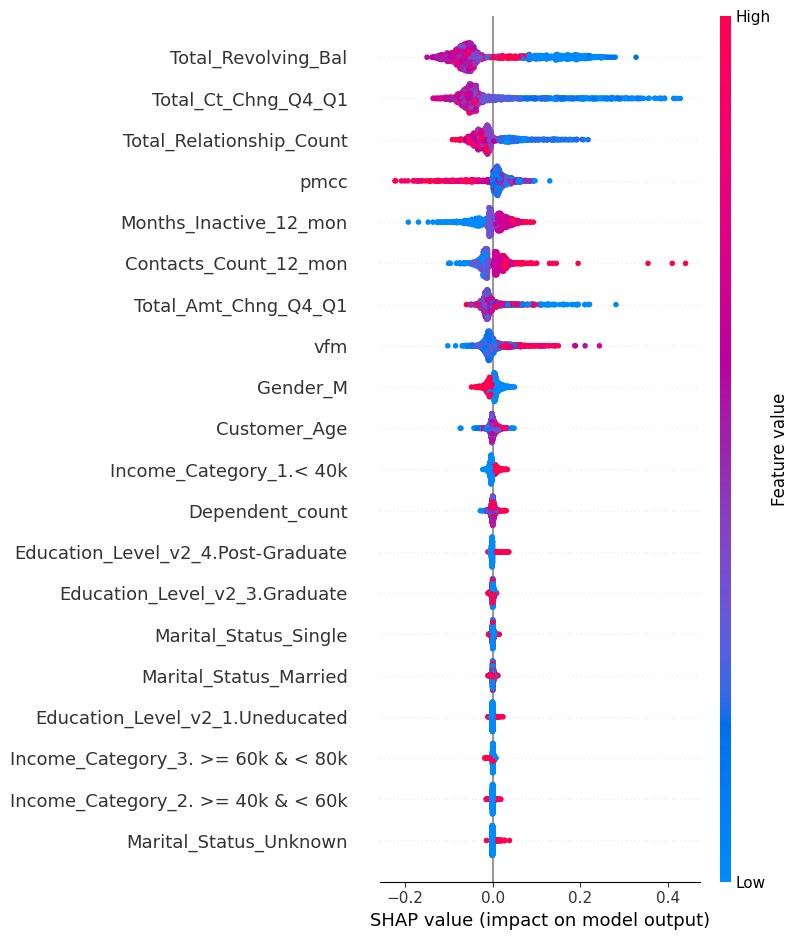

In [47]:
shap.summary_plot(shap_values.values[:,:,1], X_val)

Clientes com valor financeiro médio (vfm) abaixo do valor médio e que possuem quantidade de transações (entre o último e primeiro trimestre) abaixo da média são os clientes mais propensos a serem churn.

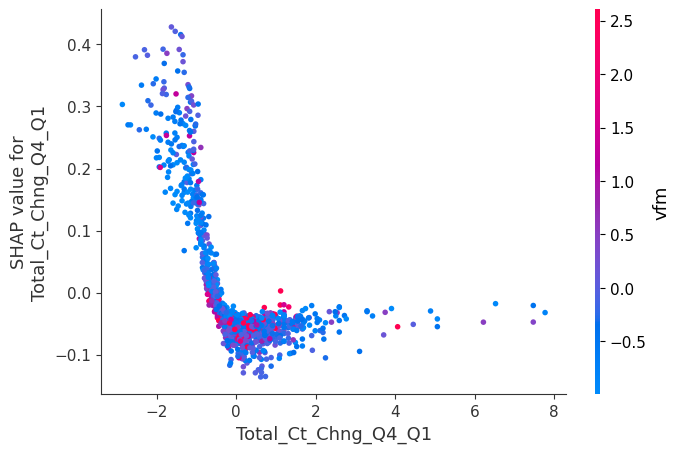

In [65]:
shap.dependence_plot('Total_Ct_Chng_Q4_Q1', shap_values.values[:,:,1], X_val, interaction_index = 'vfm')

Clientes com valores de proporção média mensal de cartão de crédito (pmcc) acima de um desvio padrão e que possuem baixos valores de saldo rotativo (por exemplo, 0.5 desvio padrão do valor médio ou 1 desvio padrão abaixo do valor médio) são candidatos a não serem clientes churn.

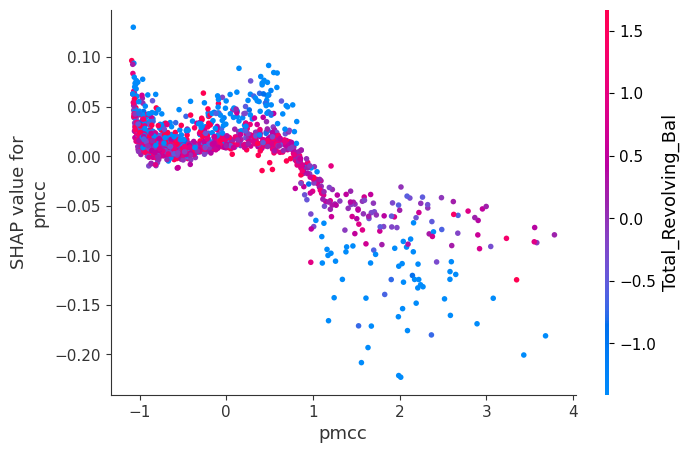

In [76]:
shap.dependence_plot('pmcc', shap_values.values[:,:,1], X_val)

Clientes com valores de proporção média mensal de cartão de crédito (pmcc) acima de um desvio padrão e que são do sexo feminino (Gender_M = 0) são candidatos a não serem churn.

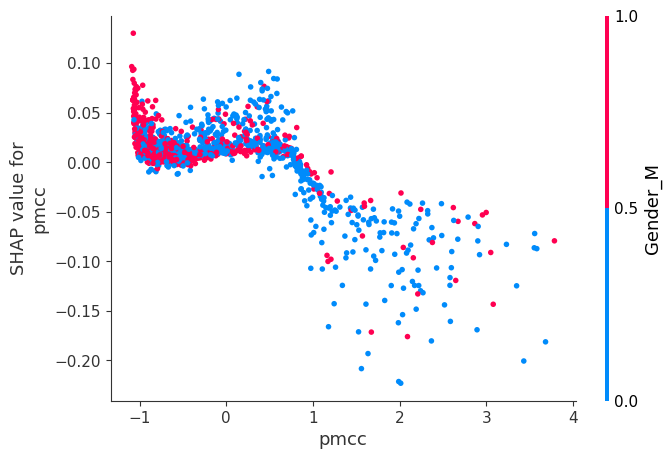

In [75]:
shap.dependence_plot('pmcc', shap_values.values[:,:,1], X_val, interaction_index='Gender_M')

Será avaliado o comportamento de dois clientes, um com baixa probabilidade de se tornar um churn e outro com alta probabilidade de se tornar um churn. Aqui, a definição de alta e baixa probabilidade fica a critério do analista. Será considerado de baixa probabilidade, clientes com probabilidade abaixo de 0.4 e com alta probabilidade clientes com probabilidade acima de 0.7. Isso será importante para visualizar o impacto das variáveis na probabilidade ou função estimada final $\hat{f}(X|\theta)$.

In [83]:
X_val.shape

(1292, 26)

In [82]:
X_val_new = pd.concat([X_val.reset_index(drop=True), pd.Series(rf.predict_proba(X_val)[:,1])], axis=1).rename(columns={0: 'Prob_est'})
X_val_new.shape

(1292, 27)

In [87]:
X_val_new[X_val_new.Prob_est >= 0.7].head()

,Customer_Age,Dependent_count,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,vfm,pmcc,...,Income_Category_4. >= 80k & < 120k,Income_Category_5. >= 120k,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Education_Level_v2_1.Uneducated,Education_Level_v2_2.High School,Education_Level_v2_3.Graduate,Education_Level_v2_4.Post-Graduate,Prob_est
2,-0.032063,0.494019,-1.168954,0.641818,-0.410543,-1.410355,-1.837965,-1.763690,-0.178650,-0.887956,...,0,0,0,0,0,0,1,0,0,0.91
3,0.344004,1.267345,-1.168954,-0.348040,-0.410543,-1.410355,-0.633818,-1.165231,0.677747,-0.865029,...,0,1,0,0,1,0,0,1,0,0.72
22,-0.282774,-1.052632,-0.525933,-0.348040,1.408428,-1.410355,-0.460494,-1.437258,0.201866,-0.251687,...,0,0,0,0,0,0,0,1,0,0.94
45,0.344004,0.494019,-1.811975,-0.348040,1.408428,-1.410355,-1.185719,-1.843205,0.203259,-0.926596,...,0,0,0,0,0,0,0,1,0,0.94
48,-0.282774,-0.279306,0.117089,0.641818,0.498943,-1.410355,-1.162913,-1.215451,-0.243537,0.147080,...,0,0,0,0,0,0,0,1,0,0.94


In [86]:
X_val_new[X_val_new.Prob_est <= 0.4].head()

,Customer_Age,Dependent_count,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,vfm,pmcc,...,Income_Category_4. >= 80k & < 120k,Income_Category_5. >= 120k,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Education_Level_v2_1.Uneducated,Education_Level_v2_2.High School,Education_Level_v2_3.Graduate,Education_Level_v2_4.Post-Graduate,Prob_est
0,1.096137,1.267345,0.117089,-0.348040,-0.410543,-0.363827,-1.377288,-0.265450,-0.736429,-1.047237,...,0,1,0,0,0,0,0,1,0,0.14
1,-1.410973,0.494019,-0.525933,0.641818,-0.410543,-1.410355,0.620501,1.341601,-0.886855,-0.845626,...,0,0,0,0,0,0,0,0,0,0.10
4,1.221492,-1.052632,-0.525933,-1.337898,-1.320028,1.666877,0.698041,-0.139899,-0.151148,0.413415,...,0,0,0,0,0,0,1,0,0,0.08
5,1.096137,-0.279306,-1.168954,0.641818,-1.320028,-0.352824,-0.629257,-0.236155,0.086163,-0.864334,...,0,1,0,0,0,0,0,1,0,0.11
6,-0.282774,0.494019,-0.525933,-1.337898,-2.229514,-0.446963,-0.332782,0.902173,-0.719425,-1.003084,...,0,0,0,0,0,0,0,1,0,0.05


In [10]:
rf.predict_proba(pd.DataFrame(X_val.iloc[0, :]).transpose())

array([[0.86, 0.14]])

In [14]:
rf.predict_proba(pd.DataFrame(X_val.iloc[2, :]).transpose())

array([[0.09, 0.91]])

In [113]:
explainer.expected_value

array([0.83949692, 0.16050308])

O valor base, 0.16, está bem próximo do valor estimado pelo modelo, 0.14, para o cliente com baixa propensão a se tornar um churn. Para o cliente com alta propensão a se tornar um churn, o valor estimado pelo modelo é bem alto, 0.91.

Abaixo, veja as principais características que os diferem:

1. o cliente com baixa probabilidade está a um desvio padrão acima da média de idade dos clientes (em treino), enquanto o cliente com alta probabilidade assume uma idade próxima a média de idade dos clientes (em treino);

2. o cliente com baixa probabilidade possui uma quantidade de produtos próxima do valor médio da base (em treino), enquanto o cliente com alta probabilidade está a um desvio padrão abaixo do valor médio da base (em treino);

3. o cliente com baixa probabilidade está a menos do que meio desvio padrão abaixo da média de saldo rotativo total dos clientes (em treino), enquanto que o cliente com alta probabilidade está a um desvio padrão e meio abaixo da média de saldo rotativo total dos clientes (em treino);

4. o cliente com baixa probabilidade está a menos do que meio desvio padrão abaixo da média (em treino) da relação de quantidade de transações entre o 4º e 1º trimestre, enquanto que o cliente com alta probabilidade está a quase dois desvio padrão abaixo da média (em treino).

Acima, foi destacado a parte "(em treino)", porque a padronização foi realizada com referência nos valores de treino!

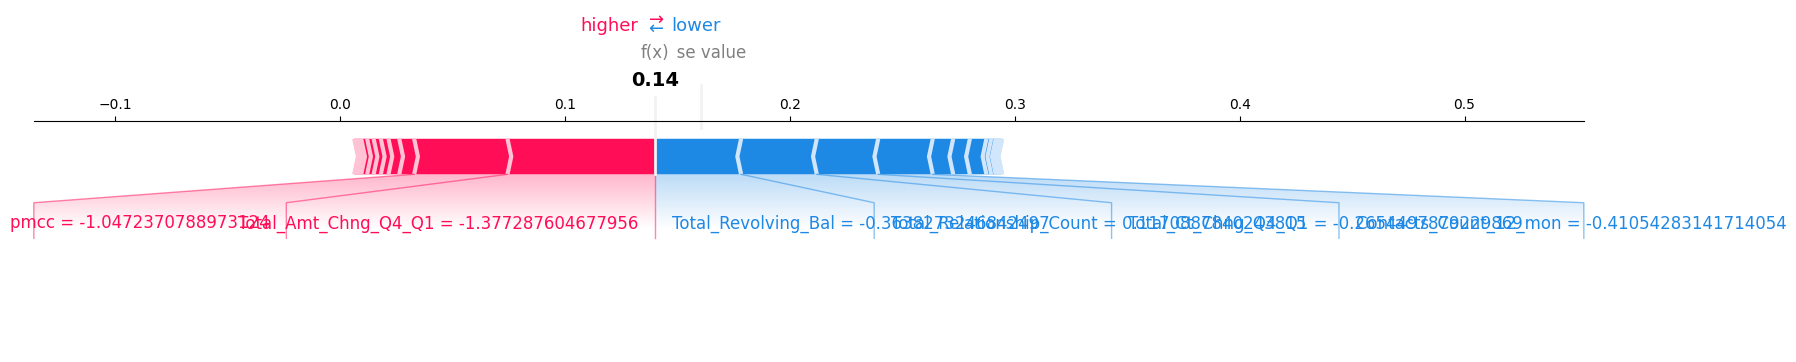

In [12]:
# Cliente com baixa propensão a churn

shap.force_plot(explainer.expected_value[1], shap_values[0].values[:,1], X_val.iloc[0, :], matplotlib = True)

In [9]:
X_val.iloc[0, :]

Customer_Age                          1.096137
Dependent_count                       1.267345
Total_Relationship_Count              0.117089
Months_Inactive_12_mon               -0.348040
Contacts_Count_12_mon                -0.410543
Total_Revolving_Bal                  -0.363827
Total_Amt_Chng_Q4_Q1                 -1.377288
Total_Ct_Chng_Q4_Q1                  -0.265450
vfm                                  -0.736429
pmcc                                 -1.047237
Gender_M                              1.000000
Marital_Status_Married                1.000000
Marital_Status_Single                 0.000000
Marital_Status_Unknown                0.000000
Income_Category_1.< 40k               0.000000
Income_Category_2. >= 40k & < 60k     0.000000
Income_Category_3. >= 60k & < 80k     0.000000
Income_Category_4. >= 80k & < 120k    0.000000
Income_Category_5. >= 120k            1.000000
Card_Category_Gold                    0.000000
Card_Category_Platinum                0.000000
Card_Category

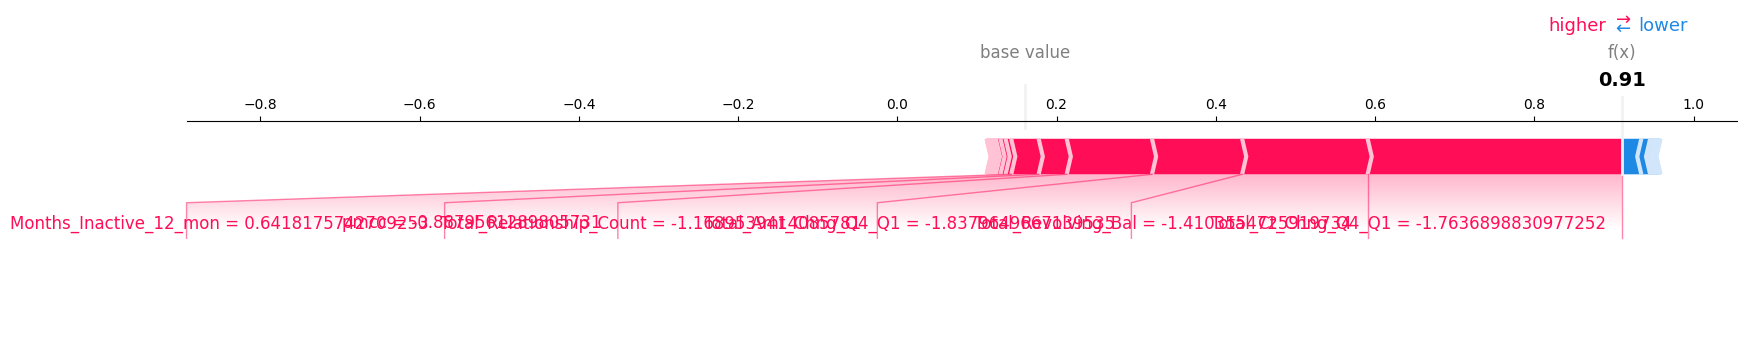

In [15]:
# Cliente com alta propensão a churn

shap.force_plot(explainer.expected_value[1], shap_values[2].values[:,1], X_val.iloc[2, :], matplotlib = True)

In [10]:
X_val.iloc[2, :]

Customer_Age                         -0.032063
Dependent_count                       0.494019
Total_Relationship_Count             -1.168954
Months_Inactive_12_mon                0.641818
Contacts_Count_12_mon                -0.410543
Total_Revolving_Bal                  -1.410355
Total_Amt_Chng_Q4_Q1                 -1.837965
Total_Ct_Chng_Q4_Q1                  -1.763690
vfm                                  -0.178650
pmcc                                 -0.887956
Gender_M                              0.000000
Marital_Status_Married                1.000000
Marital_Status_Single                 0.000000
Marital_Status_Unknown                0.000000
Income_Category_1.< 40k               0.000000
Income_Category_2. >= 40k & < 60k     1.000000
Income_Category_3. >= 60k & < 80k     0.000000
Income_Category_4. >= 80k & < 120k    0.000000
Income_Category_5. >= 120k            0.000000
Card_Category_Gold                    0.000000
Card_Category_Platinum                0.000000
Card_Category

## XGBoost - scikit-learn 1.4.2 - downgrade

Ao ajustar o XGBoost, obtive um erro: 'AttributeError: 'super' object has no attribute '__sklearn_tags__'', também reportado, no mesmo período dessa análise, como uma issue no github https://github.com/scikit-learn/scikit-learn/issues/30542; https://github.com/dmlc/xgboost/pull/11021.

Pelas métricas de treino e validação, é possível identificar que o modelo se sobreajustou. A métrica AUC-PR mostra que se perde cerca de 14% da área sobre esta curva quando se compara validação (86%) e treino (100%).

Quando as métricas logadas são comparadas com o modelo de RF, na base de validação, nota-se um ganho interessante de aproximadamente: aumento de 6 p.p. na área sob a curva PR; redução de cerca de 2 p.p.; aumento do f1 score em 7 p.p., sendo que a grande diferença se encontrou no recall em 10 p.p..

In [7]:
import sklearn
sklearn.__version__

'1.4.2'

In [44]:
#!pip install scikit-learn==1.4.2

In [8]:
# Não se aceita os sinais de maior, menor, maior igual e menor igual no .fit do xgboost

X_treino_new = X_treino.rename(columns={'Income_Category_1.< 40k': 'Income_Category_1.40k',
                                        'Income_Category_2. >= 40k & < 60k': 'Income_Category_2.40k_60k',
                                        'Income_Category_3. >= 60k & < 80k': 'Income_Category_3.60k_80k',
                                        'Income_Category_4. >= 80k & < 120k': 'Income_Category_4.80k_120k',
                                        'Income_Category_5. >= 120k': 'Income_Category_5.120k'
                                        })

X_val_new = X_val.rename(columns={'Income_Category_1.< 40k': 'Income_Category_1.40k',
                                  'Income_Category_2. >= 40k & < 60k': 'Income_Category_2.40k_60k',
                                  'Income_Category_3. >= 60k & < 80k': 'Income_Category_3.60k_80k',
                                  'Income_Category_4. >= 80k & < 120k': 'Income_Category_4.80k_120k',
                                  'Income_Category_5. >= 120k': 'Income_Category_5.120k'
                                  })

In [9]:
if __name__ == '__main__':
    
    with mlflow.start_run(run_name = 'Baseline_XGB', experiment_id = experiment.experiment_id) as run: 

        XGB = xgb.XGBClassifier()
        XGB.fit(X_treino_new, y_treino)

        # Log dos parâmetros do modelo
        mlflow.log_params(XGB.get_params())

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, XGB.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, XGB.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, XGB.predict_proba(X_treino_new)[:,1]))

            # OBS: o ponto de corte utilizado é o 0.5 (ainda não otimizamos esse ponto)
        mlflow.log_metric('F1_Treino', f1_score(y_treino, XGB.predict(X_treino_new)))
        mlflow.log_metric('Precision_Treino', precision_score(y_treino, XGB.predict(X_treino_new)))
        mlflow.log_metric('Recall_Treino', recall_score(y_treino, XGB.predict(X_treino_new)))
        mlflow.log_metric('Acuracia_Treino', accuracy_score(y_treino, XGB.predict(X_treino_new)))

        # Log das métricas na base de VALIDAÇÃO
        mlflow.log_metric('AUC_PR_Val', average_precision_score(y_val, XGB.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('AUC_ROC_Val', roc_auc_score(y_val, XGB.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('BS_Val', brier_score_loss(y_val, XGB.predict_proba(X_val_new)[:,1]))

                    # OBS: o ponto de corte utilizado é o 0.5 (ainda não otimizamos esse ponto)
        mlflow.log_metric('F1_Val', f1_score(y_val, XGB.predict(X_val_new)))
        mlflow.log_metric('Precision_Val', precision_score(y_val, XGB.predict(X_val_new)))
        mlflow.log_metric('Recall_Val', recall_score(y_val, XGB.predict(X_val_new)))
        mlflow.log_metric('Acuracia_Val', accuracy_score(y_val, XGB.predict(X_val_new)))
        
        # Log do schema das variáveis do modelo e do modelo
        signature = infer_signature(X_treino_new, XGB.predict_proba(X_treino_new))
        mlflow.sklearn.log_model(XGB, signature=signature, artifact_path='modelo')

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [9]:
logged_model = 'runs:/f1d9378ad1184a63bd1a138ace318ed5/modelo'

# Carrega o modelo com a flavor da sklearn

XGB = mlflow.sklearn.load_model(logged_model)

# Predict em um Pandas DataFrame

XGB.predict_proba(X_treino_new)

array([[9.9773926e-01, 2.2607388e-03],
       [9.6415657e-01, 3.5843451e-02],
       [9.7632760e-01, 2.3672422e-02],
       ...,
       [9.9422812e-01, 5.7718861e-03],
       [9.4750798e-01, 5.2492023e-02],
       [9.9994069e-01, 5.9304664e-05]], dtype=float32)

### Importância das variáveis

As cinco primeiras variáveis mais importantes coincidem com as cinco variáveis mais importantes em termos de IV. Diferente da RF, com 12 variáveis para acumular 91% de importância, aqui 20 variáveis foram necessárias para alcançar 91% de importância.

In [11]:
np.cumsum(np.sort(XGB.feature_importances_)[::-1])

array([0.12603739, 0.23119791, 0.3047449 , 0.37823075, 0.44733506,
       0.503473  , 0.55846393, 0.60545623, 0.64457196, 0.67667246,
       0.7077423 , 0.73774815, 0.7663357 , 0.79036164, 0.8136953 ,
       0.836859  , 0.859749  , 0.88039786, 0.89999115, 0.91895163,
       0.937711  , 0.95634335, 0.97280246, 0.9876423 , 0.99999994,
       0.99999994], dtype=float32)

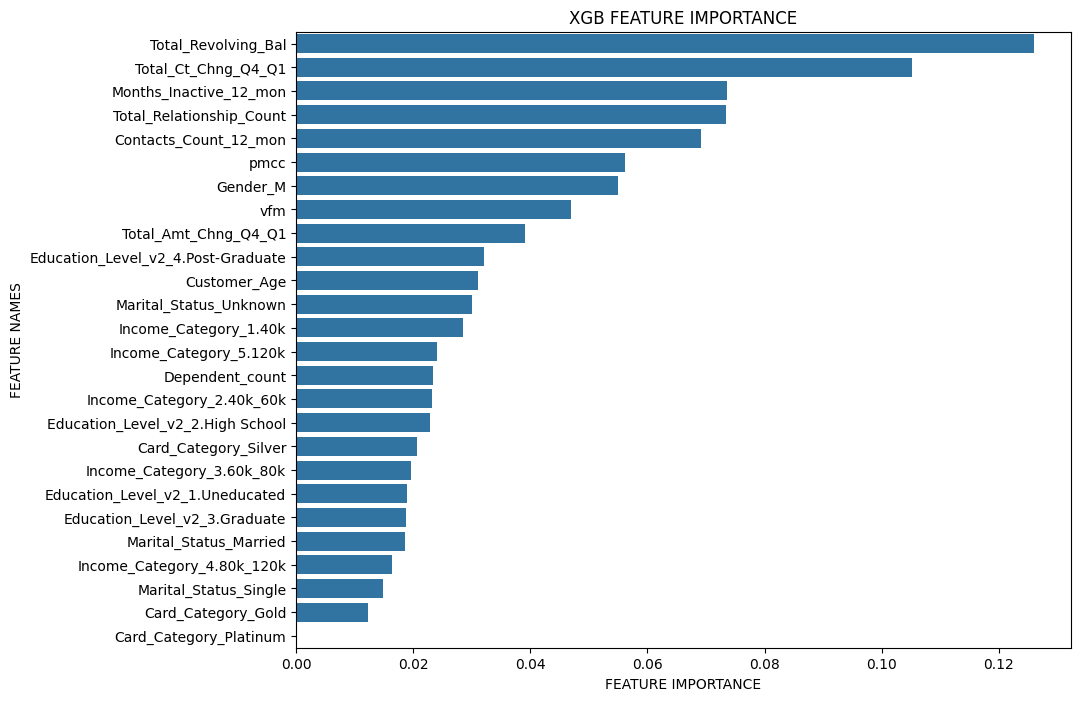

In [11]:
Funcoes.plot_feature_importance(XGB.feature_importances_, XGB.feature_names_in_, 'XGB')

### Curva de calibração e histograma das probabilidades preditas

Na base de treino, é possível ver que as probabilidades preditas conseguem separar bem o público que é churn do que não é. Na curva de calibração por decil, é possível ver que os primeiros 8 decis são um pouco superestimados. Na curva de calibração com intervalos com mesmo comprimento, é mais nítido a subestimação e superestimação nos intervalos.

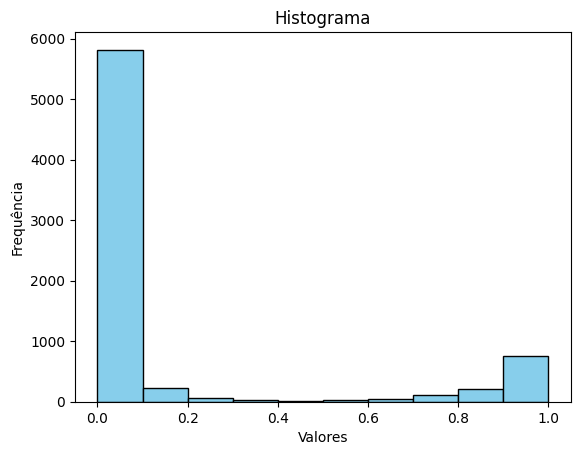

In [12]:
Funcoes.plot_histograma('Prob_predita', pd.DataFrame(XGB.predict_proba(X_treino_new)[:,1]).rename(columns={0: 'Prob_predita'}), label=None)

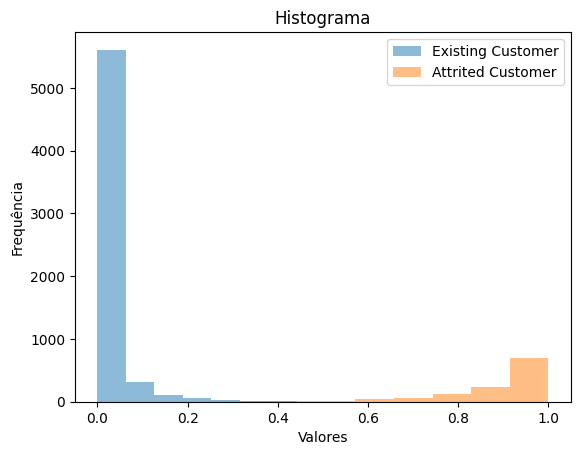

In [14]:
Funcoes.plot_histograma('Prob_predita', pd.concat([pd.Series(XGB.predict_proba(X_treino_new)[:,1]).reset_index(drop = True), y_treino.reset_index(drop = True)], axis=1).rename(columns={0: 'Prob_predita'}), label='Attrition_Flag')

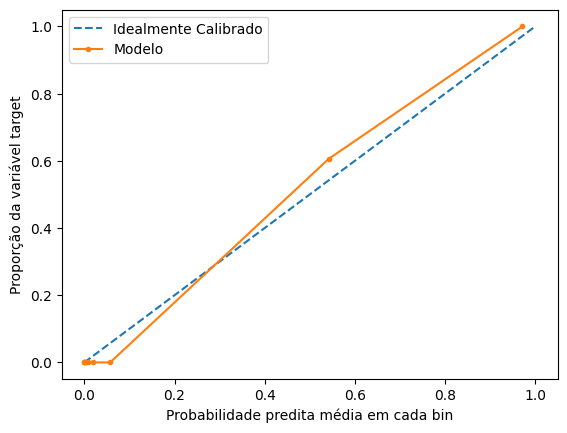

In [15]:
Funcoes.grafico_calibracao(y_treino, XGB.predict_proba(X_treino_new)[:,1], nbins=10, strategy='quantile')

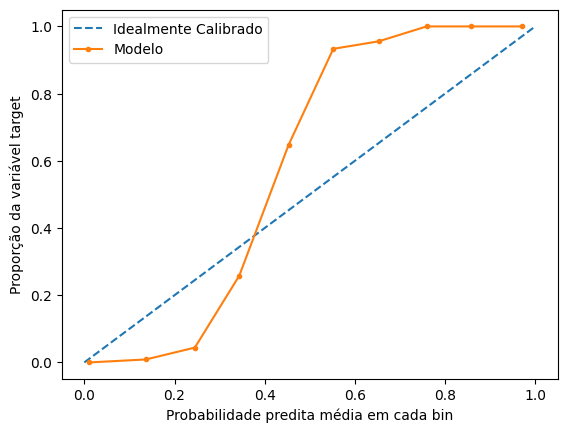

In [16]:
Funcoes.grafico_calibracao(y_treino, XGB.predict_proba(X_treino_new)[:,1], nbins=10, strategy='uniform')

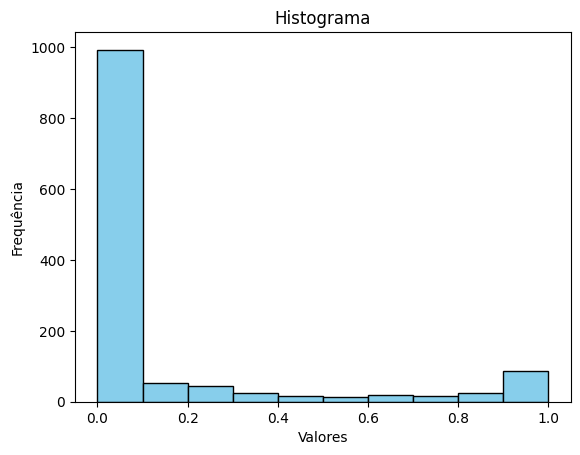

In [13]:
Funcoes.plot_histograma('Prob_predita', pd.DataFrame(XGB.predict_proba(X_val_new)[:,1]).rename(columns={0: 'Prob_predita'}), label=None)

Na base de validação, é possível notar que o modelo mapeou com baixa probabilidade os clientes que realmente não são churn (concentração próxima de zero), comentendo alguns erros.

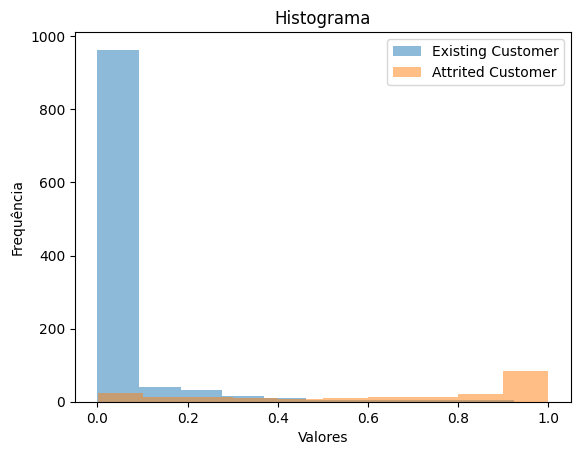

In [14]:
Funcoes.plot_histograma('Prob_predita', pd.concat([pd.Series(XGB.predict_proba(X_val_new)[:,1]).reset_index(drop = True), pd.Series(y_val).reset_index(drop = True)], axis=1).rename(columns={0: 'Prob_predita'}), label='Attrition_Flag')

In [9]:
precision, recall, thresholds = precision_recall_curve(y_val, XGB.predict_proba(X_val_new)[:,1])

O ponto de corte que fornece o melhor f1-score é bem próximo daquele encontrado no modelo RF.

In [11]:
f1_scores = 2 * (precision*recall) / (precision + recall)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1 = f1_scores[best_threshold_index]

print('Valor ótimo do f1-score:', best_f1,', com o ponto de corte ótimo:', best_threshold)

Valor ótimo do f1-score: 0.7703703703703703 , com o ponto de corte ótimo: 0.31642705


In [17]:
# Melhor threshold que fornece a melhor precisão (foco total no PPV)

best_threshold_index_v2 = np.argmax(precision)
best_threshold_v2 = thresholds[best_threshold_index_v2]
best_PPV = precision[best_threshold_index_v2]

print('Valor ótimo da precisão:', best_PPV,', com o ponto de corte ótimo:', best_threshold_v2)

Valor ótimo da precisão: 1.0 , com o ponto de corte ótimo: 0.923733


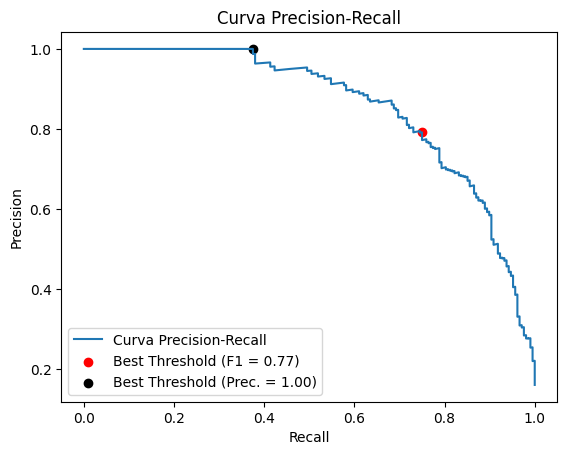

In [18]:
# Gráfico da curva PR

plt.plot(recall, precision, label='Curva Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')

# Pontos ótimo para o f1 score
plt.scatter(recall[best_threshold_index], precision[best_threshold_index], color='red', label=f'Best Threshold (F1 = {best_f1:.2f})')
plt.legend(loc='best')

plt.scatter(recall[best_threshold_index_v2], precision[best_threshold_index_v2], color='black', label=f'Best Threshold (Prec. = {best_PPV:.2f})')
plt.legend(loc='best')

plt.show()

As curvas de calibração na base de validação se mostraram melhores ajustadas do que as mostradas no modelo RF.

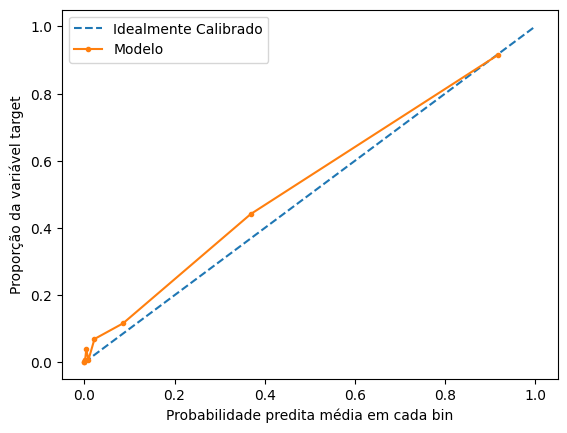

In [19]:
Funcoes.grafico_calibracao(y_val, XGB.predict_proba(X_val_new)[:,1], nbins=10, strategy='quantile')

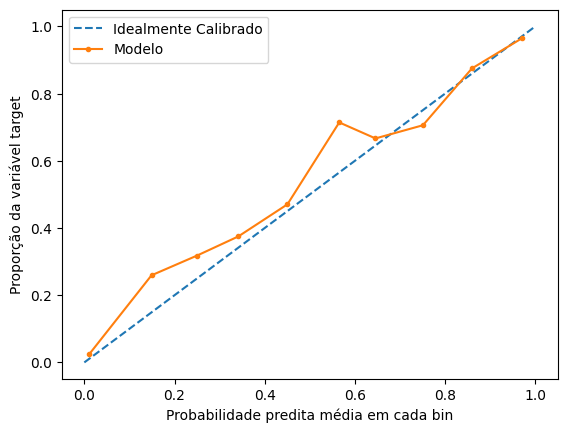

In [20]:
Funcoes.grafico_calibracao(y_val, XGB.predict_proba(X_val_new)[:,1], nbins=10, strategy='uniform')

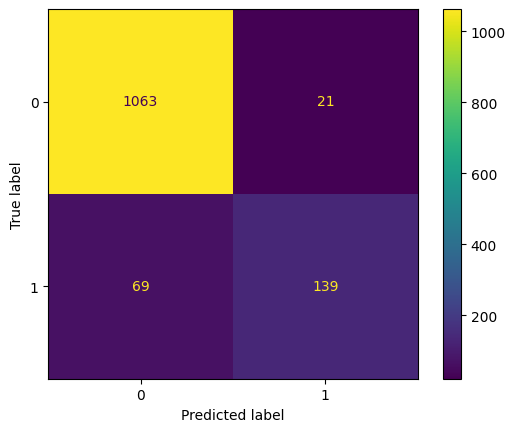

In [11]:
confusion_matrix = confusion_matrix(y_val, XGB.predict(X_val_new))
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [13]:
print(classification_report(y_val, XGB.predict(X_val_new)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1084
           1       0.87      0.67      0.76       208

    accuracy                           0.93      1292
   macro avg       0.90      0.82      0.86      1292
weighted avg       0.93      0.93      0.93      1292



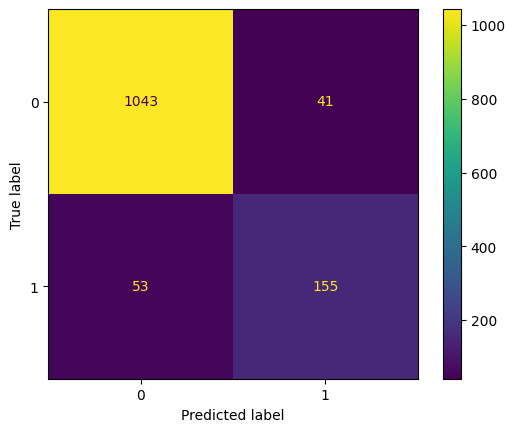

In [12]:
confusion_matrix = confusion_matrix(y_val, XGB.predict_proba(X_val_new)[:,1] > best_threshold)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

### Interpretabilidade

Será usado duas abordagens para o cálculo do SHAP. Uma considerando a log odds como output do XGBoost e outra considerando a transformação da log odds pelo logito, isto é, a probabilidade.

Para mais detalhes é possível encontrar na documentação: https://shap.readthedocs.io/en/latest/generated/shap.TreeExplainer.html#

In [162]:
explainer = shap.TreeExplainer(XGB)
shap_values = explainer(X_val_new)

In [128]:
# No shap_values.values, cada array dentro do array, representa os shap values para o cliente
# Dessa forma shap_values.values[0,:] representa os valores shap para o cliente com index 0

shap_values

.values =
array([[-1.5993291e-01, -3.0520248e-01, -5.3472203e-01, ...,
         5.6956246e-02, -8.4223986e-02,  9.1070193e-04],
       [-9.1819012e-01,  1.0365626e-01,  1.0551818e-02, ...,
         2.6238488e-02,  4.8207283e-02, -2.5951562e-02],
       [ 3.8004497e-01,  1.2463495e-02,  1.7531652e+00, ...,
        -3.8091949e-01,  3.3233214e-02, -2.4741406e-02],
       ...,
       [-2.3043369e-01, -1.1319594e-01, -3.4429869e-01, ...,
        -3.2909773e-02, -4.1543813e-03, -1.0070979e-02],
       [-1.9946842e-01, -3.2906553e-01, -5.3377038e-01, ...,
         1.6895166e-02,  2.2857543e-02,  8.9675933e-04],
       [-1.4323655e-02, -7.9032257e-02, -6.8549514e-01, ...,
         3.1199299e-02, -7.9485729e-02,  1.8900184e-01]], dtype=float32)

.base_values =
array([-1.9901096, -1.9901096, -1.9901096, ..., -1.9901096, -1.9901096,
       -1.9901096], dtype=float32)

.data =
array([[ 1.09613657,  1.26734497,  0.11708878, ...,  0.        ,
         1.        ,  0.        ],
       [-1.41097337,  

In [129]:
shap_values.values.shape

(1292, 26)

Pelo gráfico abaixo, observa-se comportamentos muito parecidos com o modelo RF. Entretanto, a ordem de importância com base no SHAP é diferente, por exemplo, pmcc e vfm passam a ser a segunda e terceira mais importantes, respectivamente. 

Comentários adiconais, que também é visto no modelo anterior, são: clientes do sexo masculino tem menor chance de se tornar churn; clientes com até 40 mil dólares de renda tem maior chanve de se tornar churn!

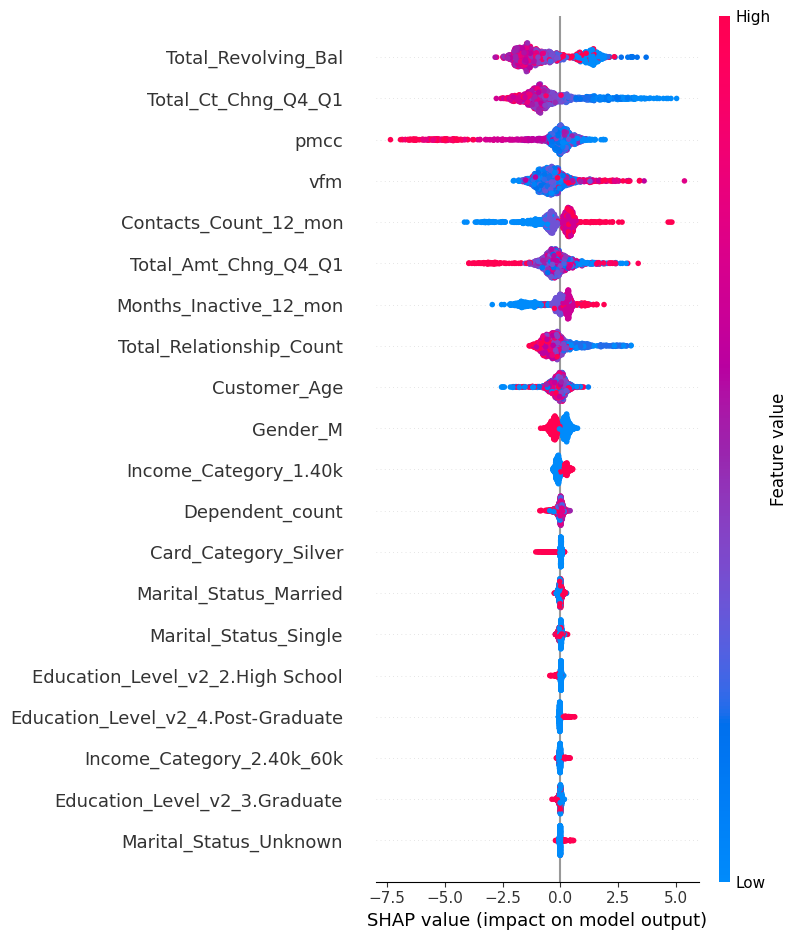

In [130]:
shap.summary_plot(shap_values.values, X_val_new)

Clientes com mais transações no quarto trimestre me relação ao terceiro e com menor proporção de uso do limite do cartão de crédito, são candidatos a não serem clientes churn.

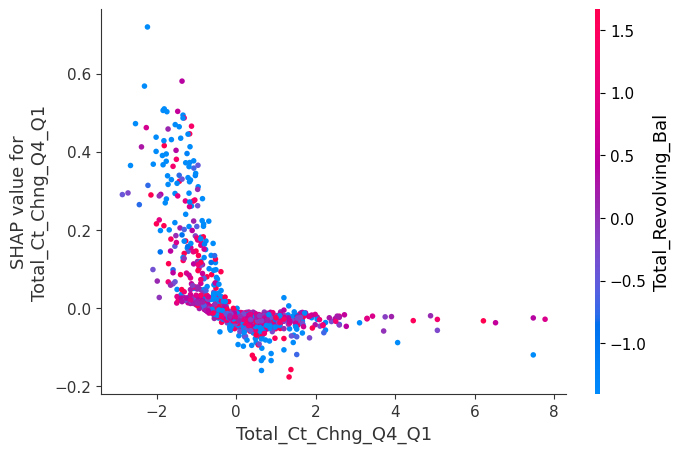

In [121]:
shap.dependence_plot('Total_Ct_Chng_Q4_Q1', shap_values.values, X_val_new)

In [164]:
explainer.expected_value

np.float32(-1.9901096)

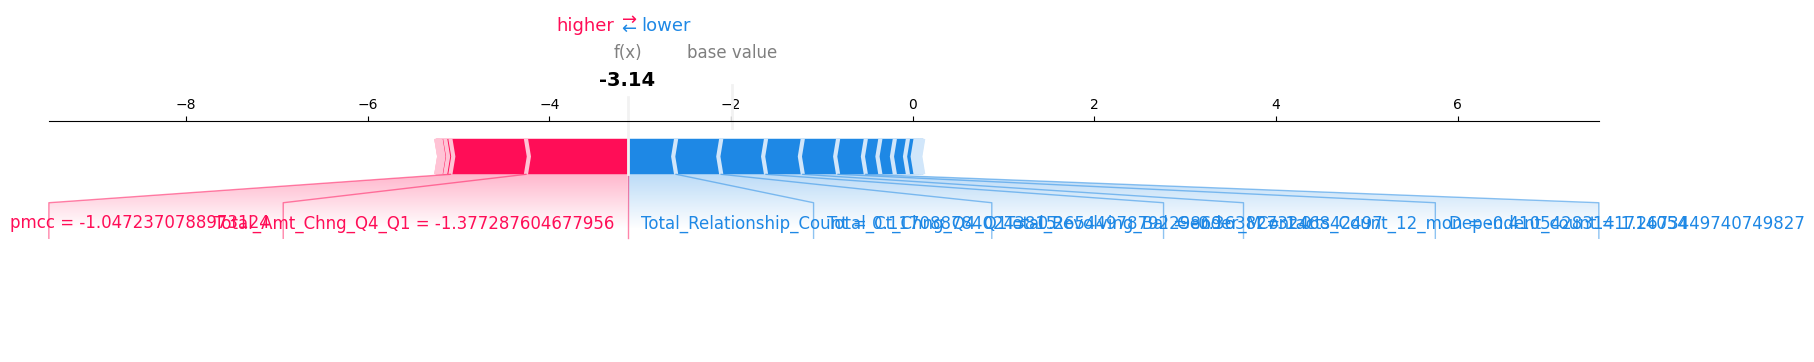

In [163]:
# Cliente com baixa propensão a churn
# Para este gráfico foi utilizado o link='logit', entretanto, a seguinte mensagem apareceu: "posx and posy should be finite values"

shap.force_plot(explainer.expected_value, shap_values.values[0,:], X_val_new.iloc[0, :], matplotlib = True)

In [165]:
# No gráfico acima, podemos estimar os valores de probabilidade aplicando o logito como feito abaixo

print("Base value: ", 1/(1+np.exp(-explainer.expected_value))) 
print("Probabilidade estimada: ", 1/(1+np.exp(-(-3.14))))

Base value:  0.12024526
Probabilidade estimada:  0.041487119301695845


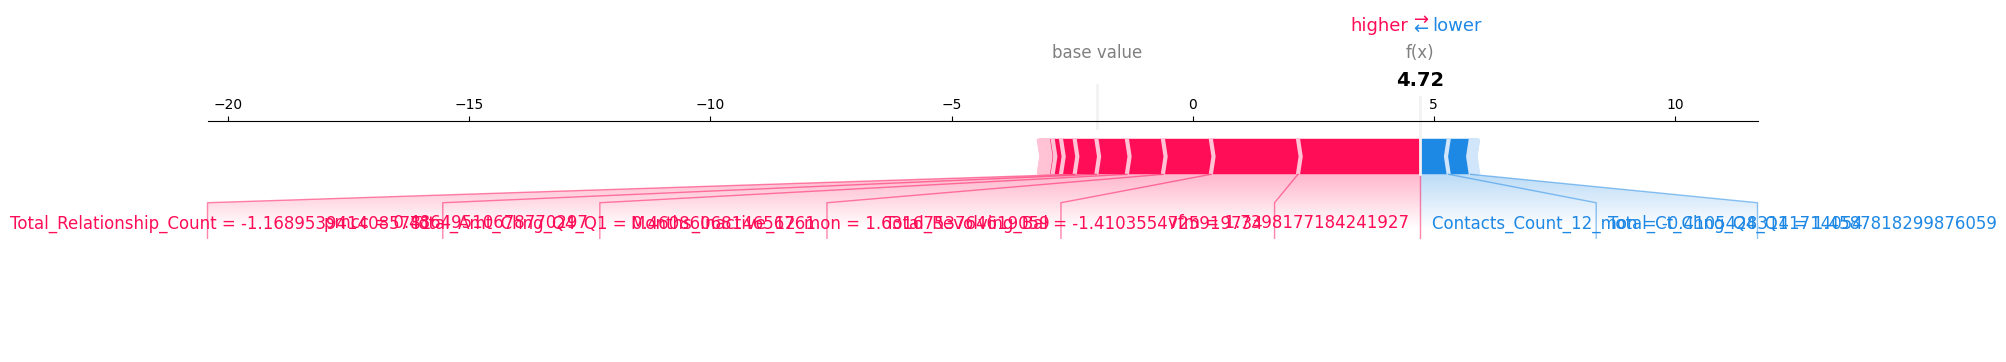

In [144]:
shap.force_plot(explainer.expected_value, shap_values.values[1000,:], X_val_new.iloc[1000, :], matplotlib = True)

In [166]:
# No gráfico acima, podemos estimar os valores de probabilidade aplicando o logito como feito abaixo

print("Base value: ", 1/(1+np.exp(-explainer.expected_value))) 
print("Probabilidade estimada: ", 1/(1+np.exp(-(4.72))))

Base value:  0.12024526
Probabilidade estimada:  0.9911635995393923


SHAP usando a probabilidade! Algumas variáveis mudaram de ordem pelo critério SHAP, entretanto, a interpretação foi a mesma.

In [167]:
explainer = shap.TreeExplainer(XGB, model_output='probability', data = X_val_new)
shap_values = explainer(X_val_new)

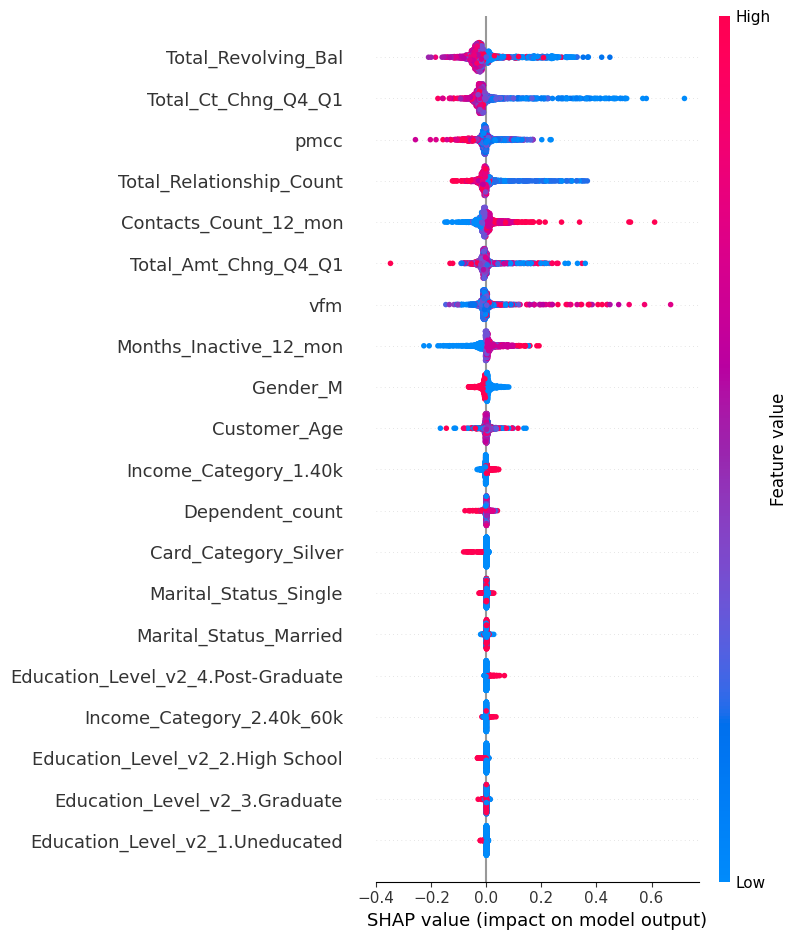

In [149]:
shap.summary_plot(shap_values.values, X_val_new)

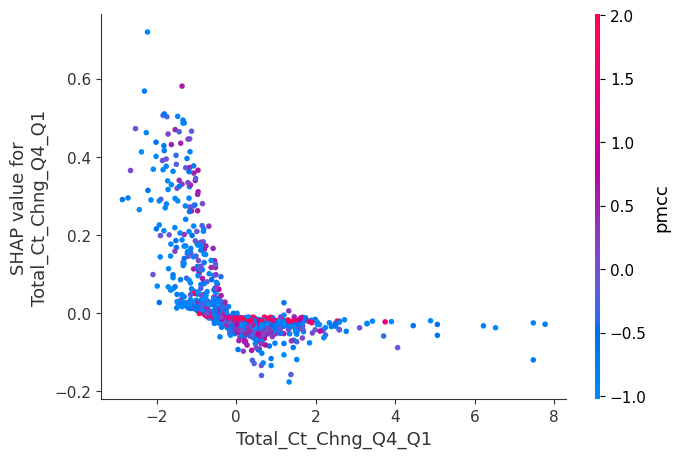

In [ ]:
# Clientes com baixa quantidade de movimentações entre o quarto e primeiro trimestre e com baixa proporção de uso do limite de cartão de crédito tem mais chance de ser churn

shap.dependence_plot('Total_Ct_Chng_Q4_Q1', shap_values.values, X_val_new, interaction_index='pmcc')

In [168]:
explainer.expected_value

np.float64(0.09976852541361515)

Abaixo, note que os valores de $f(X|\theta)$ obtifo pelo modelo é o mesmo encontrado anteriormente com a aplicação do modelo.

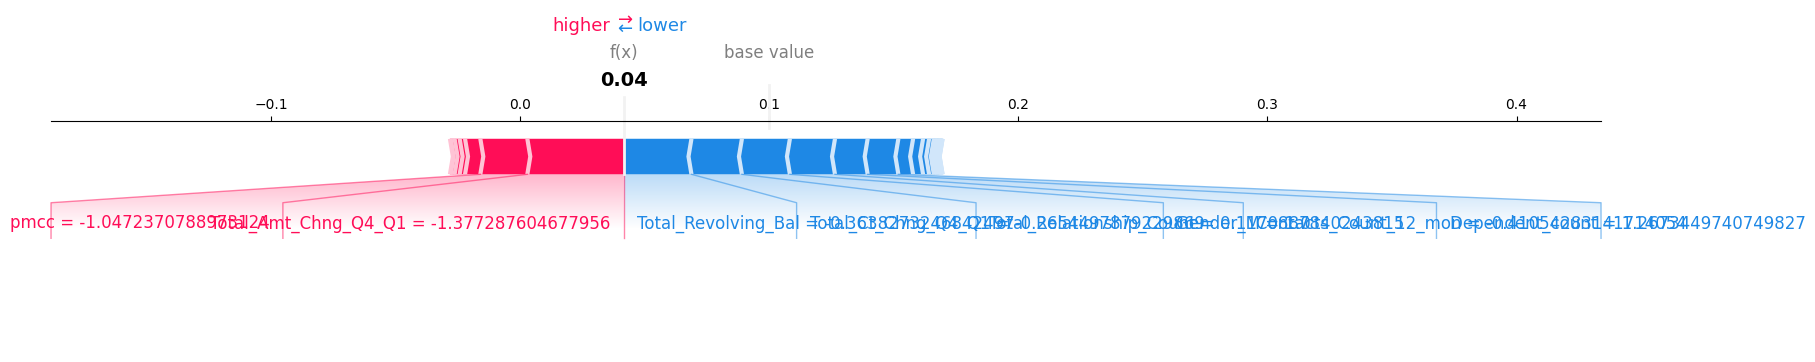

In [152]:
shap.force_plot(explainer.expected_value, shap_values.values[0,:], X_val_new.iloc[0, :], matplotlib = True)

In [172]:
X_val_new.iloc[0, :]

Customer_Age                          1.096137
Dependent_count                       1.267345
Total_Relationship_Count              0.117089
Months_Inactive_12_mon               -0.348040
Contacts_Count_12_mon                -0.410543
Total_Revolving_Bal                  -0.363827
Total_Amt_Chng_Q4_Q1                 -1.377288
Total_Ct_Chng_Q4_Q1                  -0.265450
vfm                                  -0.736429
pmcc                                 -1.047237
Gender_M                              1.000000
Marital_Status_Married                1.000000
Marital_Status_Single                 0.000000
Marital_Status_Unknown                0.000000
Income_Category_1.40k                 0.000000
Income_Category_2.40k_60k             0.000000
Income_Category_3.60k_80k             0.000000
Income_Category_4.80k_120k            0.000000
Income_Category_5.120k                1.000000
Card_Category_Gold                    0.000000
Card_Category_Platinum                0.000000
Card_Category

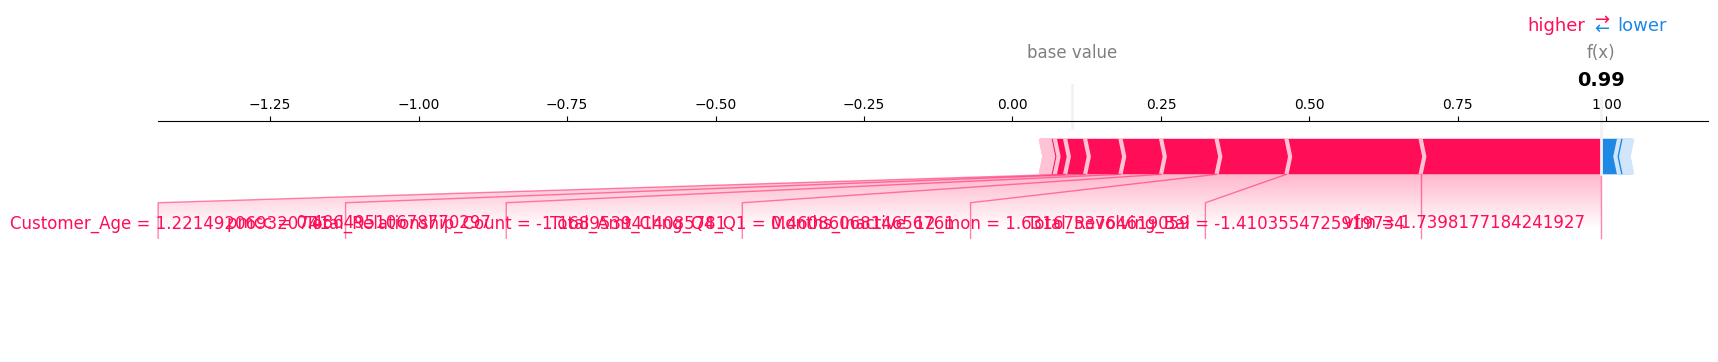

In [157]:
shap.force_plot(explainer.expected_value, shap_values.values[1000,:], X_val_new.iloc[1000, :], matplotlib = True)

In [173]:
X_val_new.iloc[1000, :]

Customer_Age                          1.221492
Dependent_count                      -0.279306
Total_Relationship_Count             -1.168954
Months_Inactive_12_mon                1.631675
Contacts_Count_12_mon                -0.410543
Total_Revolving_Bal                  -1.410355
Total_Amt_Chng_Q4_Q1                  0.460861
Total_Ct_Chng_Q4_Q1                   1.458782
vfm                                   1.739818
pmcc                                  0.486495
Gender_M                              0.000000
Marital_Status_Married                1.000000
Marital_Status_Single                 0.000000
Marital_Status_Unknown                0.000000
Income_Category_1.40k                 1.000000
Income_Category_2.40k_60k             0.000000
Income_Category_3.60k_80k             0.000000
Income_Category_4.80k_120k            0.000000
Income_Category_5.120k                0.000000
Card_Category_Gold                    0.000000
Card_Category_Platinum                0.000000
Card_Category